# 0. Preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import display

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
adult = fetch_ucirepo(id=2) 

raw_df=adult.data.original.copy()

label_column="income"
sex_column="sex"
race_column="race"
age_column="age"
predict_column="prediction"

## 0.1 The Fairness Metrics

$$Disparate Impact = \frac{P[\hat Y=1|S\ne 1]}{P[\hat Y=1|S= 1]} \geq 1- \varepsilon$$

$ S $ represents the protected attribute (e.g., race or gender), $S=1$ is the privilege group, and $S \ne 1$ is the unprivileged group. $\hat Y = 1$ means that the prediction is positive. $\varepsilon $ is a pre-determined threshold value (Pessach and Shmueli, 2022)

In [3]:
#The Confusion Matrix is a dataframe with following structure:
# |---------------------------------------------------------------------------------------|
# |                     | True Positive | False Positive | True Negative | False Negative |
# |---------------------------------------------------------------------------------------|
# | Previlleged Group   |               |                |               |                |
# |---------------------------------------------------------------------------------------|
# | Unprevilleged Group |               |                |               |                | 
# |---------------------------------------------------------------------------------------| 

def disparate_impact(confusion_matrix):
    previlleged_postive=(confusion_matrix.iloc[0][0]+confusion_matrix.iloc[0][1])/confusion_matrix.iloc[0].sum()
    unprevilleged_positive=(confusion_matrix.iloc[1][0]+confusion_matrix.iloc[1][1])/confusion_matrix.iloc[1].sum()
    return unprevilleged_positive/previlleged_postive

$$ Disparate Parity = |P[\hat Y = 1 | S \ne 1] - P[\hat Y =1 | S = 1]| \leq \varepsilon $$

$ S $ represents the protected attribute (e.g., race or gender), $S=1$ is the privilege group, and $S \ne 1$ is the unprivileged group. $\hat Y = 1$ means that the prediction is positive. $\varepsilon $ is a pre-determined threshold value. (Pessach and Shmueli, 2022)

In [4]:
#The Confusion Matrix is a dataframe with following structure:
# |---------------------------------------------------------------------------------------|
# |                     | True Positive | False Positive | True Negative | False Negative |
# |---------------------------------------------------------------------------------------|
# | Previlleged Group   |               |                |               |                |
# |---------------------------------------------------------------------------------------|
# | Unprevilleged Group |               |                |               |                | 
# |---------------------------------------------------------------------------------------| 

def disparate_parity(confusion_matrix):
    previlleged_postive=(confusion_matrix.iloc[0][0]+confusion_matrix.iloc[0][1])/confusion_matrix.iloc[0].sum()
    unprevilleged_positive=(confusion_matrix.iloc[1][0]+confusion_matrix.iloc[1][1])//confusion_matrix.iloc[1].sum()
    return  abs(unprevilleged_positive-previlleged_postive)

$$ EqualizedFPR = |P[\hat Y = 1 | S = 1, Y=0] - P[\hat Y =1 | S \ne 1, Y=0]| \leq \varepsilon $$

$$ EqualizedTPR = |P[\hat Y = 1 | S = 1, Y=1] - P[\hat Y =1 | S \ne 1, Y=1]| \leq \varepsilon $$

$ S $ represents the protected attribute (e.g., race or gender), $S=1$ is the privilege group, and $S \ne 1$ is the unprivileged group. $\hat Y = 1$ means that the prediction is positive. $Y=0$ means the actual outcome is negative, $Y=1$ means the actual outcome is positive. $\varepsilon $ is a pre-determined threshold value. (Pessach and Shmueli, 2022)

Equal opportunity only concern with $EqualizedTPR$. Equalised Odds concern with both $EqualizedTPR$ and $EqualizedFPR$ (Pessach and Shmueli, 2022)

$$ FPR = \frac{FP}{FP+TN} $$ 

$$TPR=\frac {TP}{TP+FN} $$

$TP$ is True Positive, $FP$ is False Positive, $TN$ is True Negative, $FN$ is False Negative

In [5]:
#The Confusion Matrix is a dataframe with following structure:
# |---------------------------------------------------------------------------------------|
# |                     | True Positive | False Positive | True Negative | False Negative |
# |---------------------------------------------------------------------------------------|
# | Previlleged Group   |               |                |               |                |
# |---------------------------------------------------------------------------------------|
# | Unprevilleged Group |               |                |               |                | 
# |---------------------------------------------------------------------------------------| 

def EqualizedFPR(confusion_matrix):
    previlleged_postive=confusion_matrix.iloc[0][1]/(confusion_matrix.iloc[0][1]+confusion_matrix.iloc[0][2])
    unprevilleged_positive=confusion_matrix.iloc[1][1]/(confusion_matrix.iloc[1][1]+confusion_matrix.iloc[1][2])
    return  abs(unprevilleged_positive-previlleged_postive)

def EqualizedTPR(confusion_matrix):
    previlleged_postive=confusion_matrix.iloc[0][0]/(confusion_matrix.iloc[0][0]+confusion_matrix.iloc[0][3])
    unprevilleged_positive=confusion_matrix.iloc[1][0]/(confusion_matrix.iloc[1][0]+confusion_matrix.iloc[1][3])
    return  abs(unprevilleged_positive-previlleged_postive)

# 1. Data Processing

In [6]:
df=raw_df.drop_duplicates()
#Removing Duplicates
df=df.copy()
df[label_column]=df[label_column].replace(['<=50K.','>50K.'],['<=50K','>50K'])
#cleaning faulty label in the dataset
df=df.replace(['?'],[np.nan])
#Unifiying missing values
df=df.drop("education",axis=1)
#drop column education because education-level entail this feature.

## 1.1 Normalise continous value

"fnlwgt", "capital-gain", "capital-loss" has extremely large range and very skewed distribution. So we use min-max normalisation to smooth those value.

In [7]:
def min_max_normalisation(series):
    return (series - series.min()) / (series.max() - series.min())

df["fnlwgt"]=min_max_normalisation(df["fnlwgt"])
df["capital-gain"]=min_max_normalisation(df["capital-gain"])
df["capital-loss"]=min_max_normalisation(df["capital-loss"])

## 1.2 Converting categorical values to numerical values

In [8]:
def Categorical_to_Numerical(dataframe,column):
    le=LabelEncoder()
    dataframe.loc[dataframe[column].notnull(),column] = le.fit_transform(dataframe[dataframe[column].notnull()][column])
    dataframe[column]=pd.to_numeric(dataframe[column],errors="coerce")
    return le,dict(zip(le.classes_,range(len(le.classes_))))
#Use LabelEncoder to convert categorical strings to numerical integers. return trained LabelEncoder for backward conversion and a dictionary to illustrate the mapping

def Numerical_to_Categorical(LabelEncoder,values):
    return LabelEncoder.inverse_transform([int(i) for i in values])

In [9]:
wc_le,wc_le_dict = Categorical_to_Numerical(df,"workclass")
ms_le,ms_le_dict = Categorical_to_Numerical(df,"marital-status")
op_le,op_le_dict = Categorical_to_Numerical(df,"occupation")
rs_le,rs_le_dict = Categorical_to_Numerical(df,"relationship")
race_le,race_le_dict = Categorical_to_Numerical(df,"race")
sex_le,sex_le_dict = Categorical_to_Numerical(df,"sex")
nc_le,nc_dict = Categorical_to_Numerical(df,"native-country")
income_le,income_le_dict = Categorical_to_Numerical(df,"income")

In [10]:
print(wc_le_dict)
print(ms_le_dict)
print(op_le_dict)
print(rs_le_dict)
print(race_le_dict)
print(sex_le_dict)
print(nc_dict)
print(income_le_dict)

{'Federal-gov': 0, 'Local-gov': 1, 'Never-worked': 2, 'Private': 3, 'Self-emp-inc': 4, 'Self-emp-not-inc': 5, 'State-gov': 6, 'Without-pay': 7}
{'Divorced': 0, 'Married-AF-spouse': 1, 'Married-civ-spouse': 2, 'Married-spouse-absent': 3, 'Never-married': 4, 'Separated': 5, 'Widowed': 6}
{'Adm-clerical': 0, 'Armed-Forces': 1, 'Craft-repair': 2, 'Exec-managerial': 3, 'Farming-fishing': 4, 'Handlers-cleaners': 5, 'Machine-op-inspct': 6, 'Other-service': 7, 'Priv-house-serv': 8, 'Prof-specialty': 9, 'Protective-serv': 10, 'Sales': 11, 'Tech-support': 12, 'Transport-moving': 13}
{'Husband': 0, 'Not-in-family': 1, 'Other-relative': 2, 'Own-child': 3, 'Unmarried': 4, 'Wife': 5}
{'Amer-Indian-Eskimo': 0, 'Asian-Pac-Islander': 1, 'Black': 2, 'Other': 3, 'White': 4}
{'Female': 0, 'Male': 1}
{'Cambodia': 0, 'Canada': 1, 'China': 2, 'Columbia': 3, 'Cuba': 4, 'Dominican-Republic': 5, 'Ecuador': 6, 'El-Salvador': 7, 'England': 8, 'France': 9, 'Germany': 10, 'Greece': 11, 'Guatemala': 12, 'Haiti': 13,

The privelleged value of sex feature after conversion is 1 and unprivelleged value is 0

The privelledged values of race feature after convsion is 4 and any value other than it is unprivelleged

## 1.3 Handling Missing Value

We decide to handle missing value by replacing them with the most propable values given other known features.

Since known feature with missing values is "workclass", "occupation" and "native country"

so we use other features to train Naive Bayes to predict the most propobal value of those features.

In [11]:
no_missing_df=df.copy().dropna().drop("income",axis=1)

impute_feature=no_missing_df.drop(["workclass","occupation","native-country"],axis=1)

workclass_label=no_missing_df["workclass"]
occupation_label=no_missing_df["occupation"]
native_label=no_missing_df["native-country"]

workclass_imputation=MultinomialNB()
workclass_imputation.fit(impute_feature,workclass_label)

occupation_imputation=MultinomialNB()
occupation_imputation.fit(impute_feature,occupation_label)

native_imputation=MultinomialNB()
native_imputation.fit(impute_feature,native_label);

In [12]:
wc_null=df["workclass"].isnull()
op_null=df["occupation"].isnull()
nc_null=df["native-country"].isnull()
unwanted_feature=["income","workclass","occupation","native-country"]
df.loc[wc_null,"workclass"]=workclass_imputation.predict(df.loc[wc_null].drop(unwanted_feature,axis=1))
df.loc[op_null,"occupation"]=occupation_imputation.predict(df.loc[op_null].drop(unwanted_feature,axis=1))
df.loc[nc_null,"native-country"]=native_imputation.predict(df.loc[nc_null].drop(unwanted_feature,axis=1))
df


,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6.0,0.044131,13,4,0.0,1,4,1,0.021740,0.0,40,38.0,0
1,50,5.0,0.048052,13,2,3.0,0,4,1,0.000000,0.0,13,38.0,0
2,38,3.0,0.137581,9,0,5.0,1,4,1,0.000000,0.0,40,38.0,0
3,53,3.0,0.150486,7,2,5.0,0,2,1,0.000000,0.0,40,38.0,0
4,28,3.0,0.220635,13,2,9.0,5,2,0,0.000000,0.0,40,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,3.0,0.137428,13,0,9.0,1,4,0,0.000000,0.0,36,38.0,0
48838,64,3.0,0.209130,9,6,7.0,2,2,1,0.000000,0.0,40,38.0,0
48839,38,3.0,0.245379,13,2,9.0,0,4,1,0.000000,0.0,50,38.0,0
48840,44,3.0,0.048444,13,0,0.0,3,1,1,0.054551,0.0,40,38.0,0


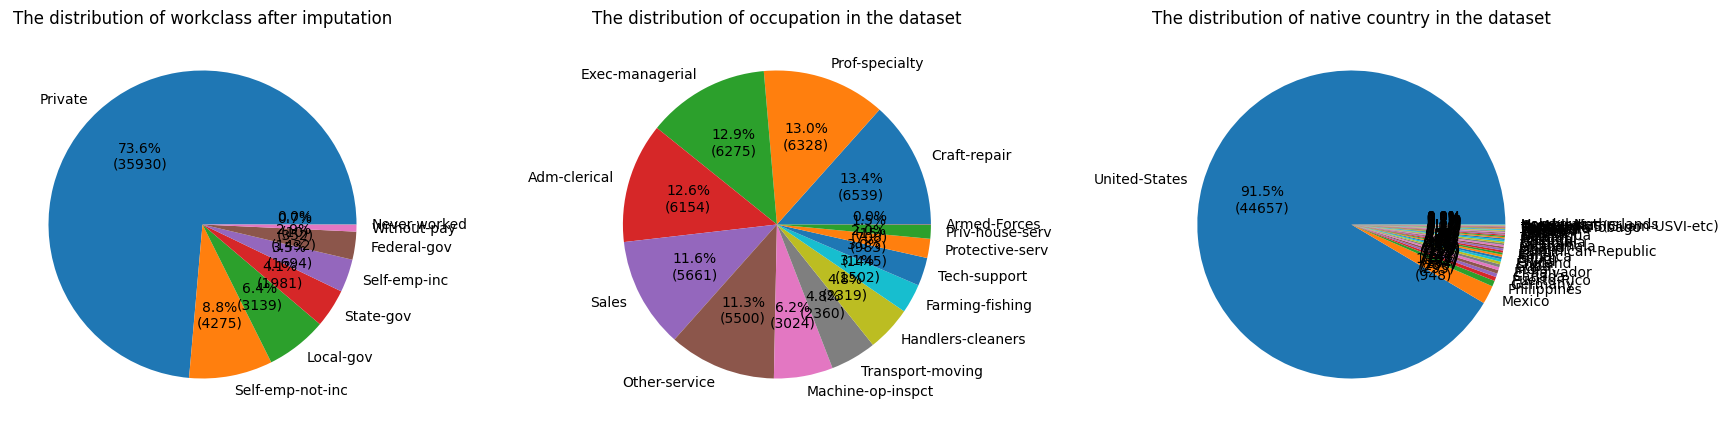

In [13]:
def autolabel(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d})"

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(21,5))

workclass_count=df["workclass"].value_counts(dropna=False)
ax1.pie(workclass_count,labels=Numerical_to_Categorical(wc_le,workclass_count.index), autopct=lambda pct: autolabel(pct, workclass_count))
ax1.set_title("The distribution of workclass after imputation")
occupation_count=df["occupation"].value_counts(dropna=False)
ax2.pie(occupation_count,labels=Numerical_to_Categorical(op_le,occupation_count.index), autopct=lambda pct: autolabel(pct, occupation_count))
ax2.set_title("The distribution of occupation in the dataset")
native_count=df["native-country"].value_counts(dropna=False)
ax3.pie(native_count,labels=Numerical_to_Categorical(nc_le,native_count.index), autopct=lambda pct: autolabel(pct, native_count))
ax3.set_title("The distribution of native country in the dataset")
plt.show()

The training set, and testing set has the split of 65:35 over the dataset.

In [14]:
train_set, test_set = train_test_split(df,test_size=0.35,train_size=0.65)
print(f"The training set has {train_set.shape[0]} entries")
print(f"The testing set has {test_set.shape[0]} entries")

The training set has 31728 entries
The testing set has 17085 entries


In [15]:
fairness_analysis=test_set.copy()[[age_column,race_column,sex_column,label_column]]
#Extract protected varaible values and label values for fairness analysis

# 2. Baseline model: Logistic Regression

In [16]:
train_X=train_set.drop("income",axis=1)
train_Y=train_set["income"]

baseline=LogisticRegression(max_iter=1000)
baseline.fit(train_X,train_Y)

LogisticRegression(max_iter=1000)

## 2.1 Confusion Matrix anlysis of the models' prediction in accordance to protected variable.

In [17]:
test_X=test_set.drop(label_column,axis=1)

pred=baseline.predict(test_X)
baseline_fairness=fairness_analysis.copy()
baseline_fairness[predict_column]=pd.Series(pred,index=test_X.index)

In [18]:
def get_confusion_matrix(df,filter, value):
    true_p,fales_p,true_n,false_n=0,0,0,0
    for index,row in df.loc[filter(df)].iterrows():
        if row[predict_column]==1:
            if row[label_column]==0:
                fales_p+=1
            if row[label_column]==1:
                true_p+=1
        if row[predict_column]==0:
            if row[label_column]==0:
                true_n+=1
            if row[label_column]==1:
                false_n+=1
    return pd.Series([true_p,fales_p,true_n,false_n],index=["Ture P","False P","True N","False N"],name=value)

In [19]:
def working_age(df):
    return (df[age_column]>=25) & (df[age_column]<65)
def not_working_age(df):
    return (df[age_column]<25) | (df[age_column]>=65)

previlleged_confusion=get_confusion_matrix(baseline_fairness,working_age,"25-65")
unprevilleged_confusion=get_confusion_matrix(baseline_fairness,not_working_age,"<25 or >=65")
age_confusion=pd.DataFrame([previlleged_confusion,unprevilleged_confusion])
print("The confusion matrix in accordance to protected variable age is")
display(age_confusion)

The confusion matrix in accordance to protected variable age is


,Ture P,False P,True N,False N
25-65,1738,668,8851,2190
<25 or >=65,110,103,3342,83


In [20]:
def male(df):
    return df[sex_column]==1
def female(df):
    return df[sex_column]==0

previlleged_confusion=get_confusion_matrix(baseline_fairness,male,"Male")
unprevilleged_confusion=get_confusion_matrix(baseline_fairness,female,"Female")
sex_confusion=pd.DataFrame([previlleged_confusion,unprevilleged_confusion])
print("The confusion matrix in accordance to protected variable sex is")
display(sex_confusion)

The confusion matrix in accordance to protected variable sex is


,Ture P,False P,True N,False N
Male,1737,705,7248,1763
Female,111,66,4945,510


In [21]:
def white(df):
    return df[race_column]==4
def nonwhite(df):
    return df[race_column]!=4

previlleged_confusion=get_confusion_matrix(baseline_fairness,white,"White")
unprevilleged_confusion=get_confusion_matrix(baseline_fairness,nonwhite,"Non White")
race_confusion=pd.DataFrame([previlleged_confusion,unprevilleged_confusion])
print("The confusion matrix in accordance to protected variable race is")
display(race_confusion)

The confusion matrix in accordance to protected variable race is


,Ture P,False P,True N,False N
White,1709,713,10141,2020
Non White,139,58,2052,253


Calculate the Fairness Metrics for the baseline model

In [22]:
def evaluate_fairness_model(cf,name_of_model):
    index_label=["Disparate Impact","Disparate Parity","Equalized FPR","Equalized TPR"]
    return pd.Series([disparate_impact(cf),disparate_parity(cf),EqualizedFPR(cf),EqualizedTPR(cf)],index=index_label,name=name_of_model)

In [23]:
baseline_performance_age=evaluate_fairness_model(age_confusion,"baseline")
display(baseline_performance_age)

Disparate Impact    0.327225
Disparate Parity    0.178925
Equalized FPR       0.040277
Equalized TPR       0.127484
Name: baseline, dtype: float64